In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectKBest, chi2
import cmath
import random

sns.set()

from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Draw

import pubchempy as pcp

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline

file = "QSARData.csv"

df = pd.read_csv(file)

print("original shape:", df.shape)
#print(df.dtypes)

## Functions

def missing_data(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['coverage (%)']=(data.shape[0]-missing_df['missing values'])/data.shape[0]*100
    missing_df.sort_values('coverage (%)').reset_index(drop = True)
    print(missing_df.loc[missing_df['coverage (%)'] < 90.0])
    #print(missing_df.loc[missing_df['coverage (%)'] < 100.0])
    less_cov = missing_df.loc[missing_df['coverage (%)'] < 90.0]
    return missing_df, less_cov
    
def variance_inflation(df, standardise=True):
    ## Calculate variance inflation factors
    X = df.copy()
    categorical = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if len(categorical) > 0:
        dummies = pd.get_dummies(X, columns = categorical, drop_first=True)
        cols = dummies.columns
        print("dummies columns: %s" % cols)
        Xc = sm.add_constant(dummies)
        vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
        vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)

        no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
        no_constant['cols'] = cols
        print(no_constant.sort_values(by='VIF', ascending=False))
    else:
        if standardise:
            cols = X.columns
            print(cols[:2])
            X_scaled = StandardScaler().fit_transform(X)
            Xc = sm.add_constant(X_scaled)
            vifs = [vif(Xc, i) for i in range(Xc.shape[1])]
            vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)
            no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
            no_constant['cols'] = cols
            no_constant_sorted = no_constant.sort_values(by='VIF', ascending=False)
        else:
            cols = X.columns
            Xc = sm.add_constant(X)
            vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
            vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)
            no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
            no_constant['cols'] = cols
            no_constant_sorted = no_constant.sort_values(by='VIF', ascending=False)
        #print(no_constant.sort_values(by='VIF', ascending=False))
        return no_constant_sorted


def strat_train_valid_test_split(y, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=None):
    if not seed is None:
        np.random.seed(seed)
    split_cd = 10
    train_cutoff = int(np.round(frac_train * split_cd))
    valid_cutoff = int(np.round(frac_valid * split_cd)) + train_cutoff
    test_cutoff = int(np.round(frac_test * split_cd)) + valid_cutoff

    train_idx = np.array([], dtype=int)
    valid_idx = np.array([], dtype=int)
    test_idx = np.array([], dtype=int)
    
    sortidx = np.argsort(y)
    i = 0
    while sortidx.shape[0] >= split_cd:
        #print("split iteration: ", i, "remaining data:", sortidx.shape[0])
        old = split_cd * i
        i +=1
        new = split_cd * i
        sortidx_split, sortidx = np.split(sortidx, [split_cd])
        shuffled = np.random.permutation(range(old, new))
        train_idx = np.hstack([train_idx, sortidx_split[shuffled[:train_cutoff]]])
        valid_idx = np.hstack(
          [valid_idx, sortidx_split[shuffled[train_cutoff:valid_cutoff]]])
        test_idx = np.hstack([test_idx, sortidx_split[shuffled[valid_cutoff:]]])

    # Append remaining examples to train
    if sortidx.shape[0] > 0: np.hstack([train_idx, sortidx])
    
    return train_idx, valid_idx, test_idx

missing_df, low_cov_data = missing_data(df)
low_cols = list(low_cov_data['variable'])
data = df.drop(columns = low_cols, axis=1)
data.drop(['Unnamed: 0'], inplace=True, axis=1)
print("shape after dropping null columns: ", data.shape)

original shape: (179, 321)
          variable  missing values  coverage (%)
219  Wgamma1.unity             179           0.0
220  Wgamma2.unity             179           0.0
221  Wgamma3.unity             179           0.0
229       WG.unity             179           0.0
shape after dropping null columns:  (179, 316)


Molecular formula:  C15H22O5
Isomeric SMILES:  C[C@@H]1CC[C@H]2[C@H](C(=O)O[C@H]3[C@@]24[C@H]1CC[C@](O3)(OO4)C)C
Canonical SMILES:  CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C
XLogP:  2.8


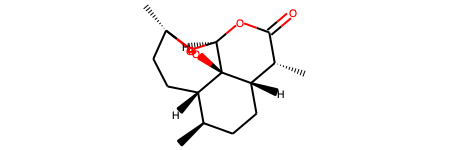

In [3]:
## Visualise the artemisinin structure

a = pcp.Compound.from_cid(68827)

print("Molecular formula: ", a.molecular_formula)
print("Isomeric SMILES: ", a.isomeric_smiles)
print("Canonical SMILES: ", a.canonical_smiles)
print("XLogP: ", a.xlogp)

m = Chem.MolFromSmiles(a.isomeric_smiles)
m

### Target variable analysis

The target variable is the log of the relative activity measure. This measure is calculated as follows:

log RA = log(IC50 artemisinin / IC50 analogue) x log (MW analogue / MW artemisinin)

The below analysis indicates that the majority of the analogues produce log RA values between -1 and 1. However, there are also about 20 compounds that exhibit the same log RA value of -4, even though they are structurally diverse. This is important and is likely to affect the models accuracy, given the inputs features are molecular descriptors. 

count    179.000000
mean      -0.611173
std        1.568864
min       -4.000000
25%       -0.925000
50%       -0.040000
75%        0.375000
max        1.470000
Name: depVar, dtype: float64


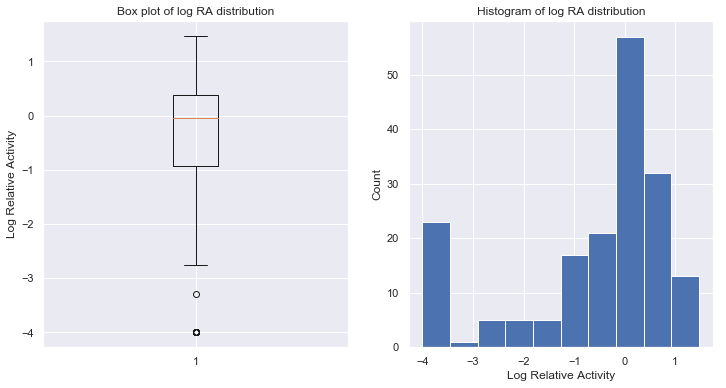

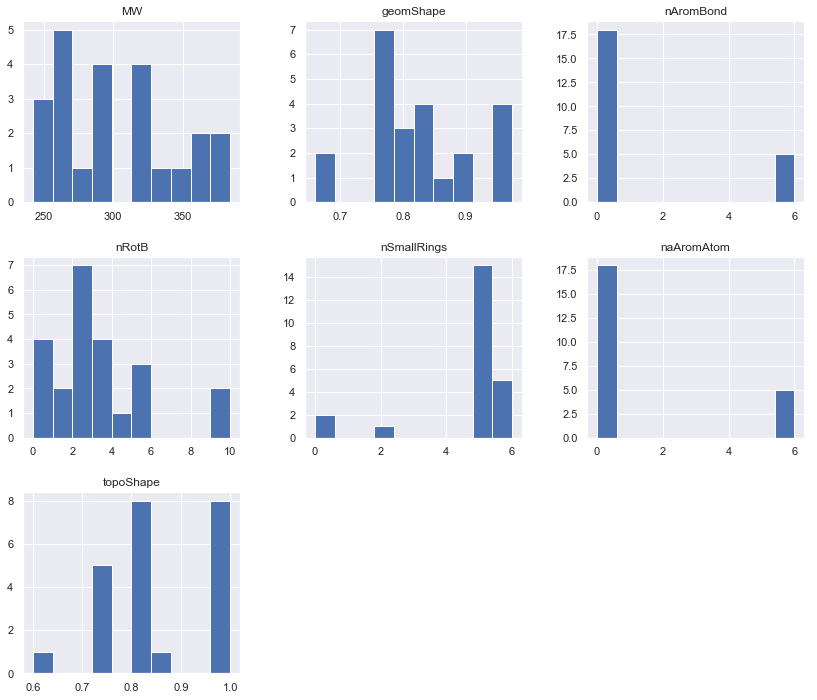

In [4]:
## Target variable analysis
x_data = data.drop('depVar', axis=1)
y = data['depVar']

fig, ax = plt.subplots(1, 2, figsize=(12,6))
print(y.describe())
ax[0].set_title("Box plot of log RA distribution")
ax[0].boxplot(data['depVar'])
ax[0].set_xlabel("")
ax[0].set_ylabel("Log Relative Activity")

ax[1].set_title("Histogram of log RA distribution")
ax[1].hist(y)
ax[1].set_xlabel("Log Relative Activity")
ax[1].set_ylabel("Count")
plt.show()

## Molecules with the same log RA value 

mol = data.loc[data['depVar'] == -4]
mol.columns.tolist()

# Geometric features 

geo = ['MW','topoShape', 'geomShape', 'nSmallRings', 'nRotB', 'nAromBond', 'naAromAtom']

mol_geo = mol[geo]
#plt.hist(mol_geo, stacked=True)
mol_geo.hist(label="Feature analysis for compounds with the same log RA value", figsize=(14,12))
plt.show()

In [6]:
## Variance threshold feature selection

# Get feature variables that have zero variance for all samples

print("original shape: ", x_data.shape)
selector = VarianceThreshold(threshold=(0))
variance = selector.fit(x_data)
#print(variance.variances_)
selector.fit_transform(x_data)

# Keep only columns that have a greater variance than 0.0 for all data samples 
#print(selector.variances_)
variance_selected = x_data[x_data.columns[selector.get_support(indices=True)]]
selected_columns = variance_selected.columns.tolist()
print("processed shape: ", variance_selected.shape)
variance_selected['RPSA.1'].head(4)



original shape:  (179, 315)
processed shape:  (179, 248)


0    0.173603
1    0.121296
2    0.214564
3    0.174046
Name: RPSA.1, dtype: float64

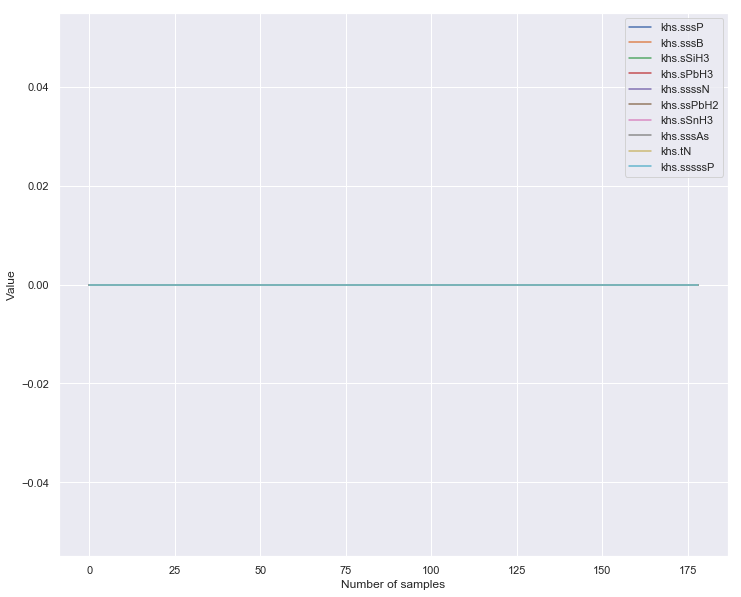

In [7]:
## randomly select 10 features to plot as a sanity check for the variance calculation
import random

unselected = x_data[x_data.columns[~x_data.columns.isin(selected_columns)]]

random = random.sample(unselected.columns.tolist(),k=10)

unselected[random].plot(figsize=(12,10))
plt.xlabel("Number of samples")
plt.ylabel("Value")
plt.show()



### Feature analysis


Correlation analysis of the feature reveals that several features have high degrees of multicollinearity. The matrix plot shows this most clearly, with yellow shaded regions corresponding to correlation coefficients ~1.0. The scatter plots below this display the top 10 most correlated features with the y-variable. The pairwise corretaions are also obvious from these scatter plots. 

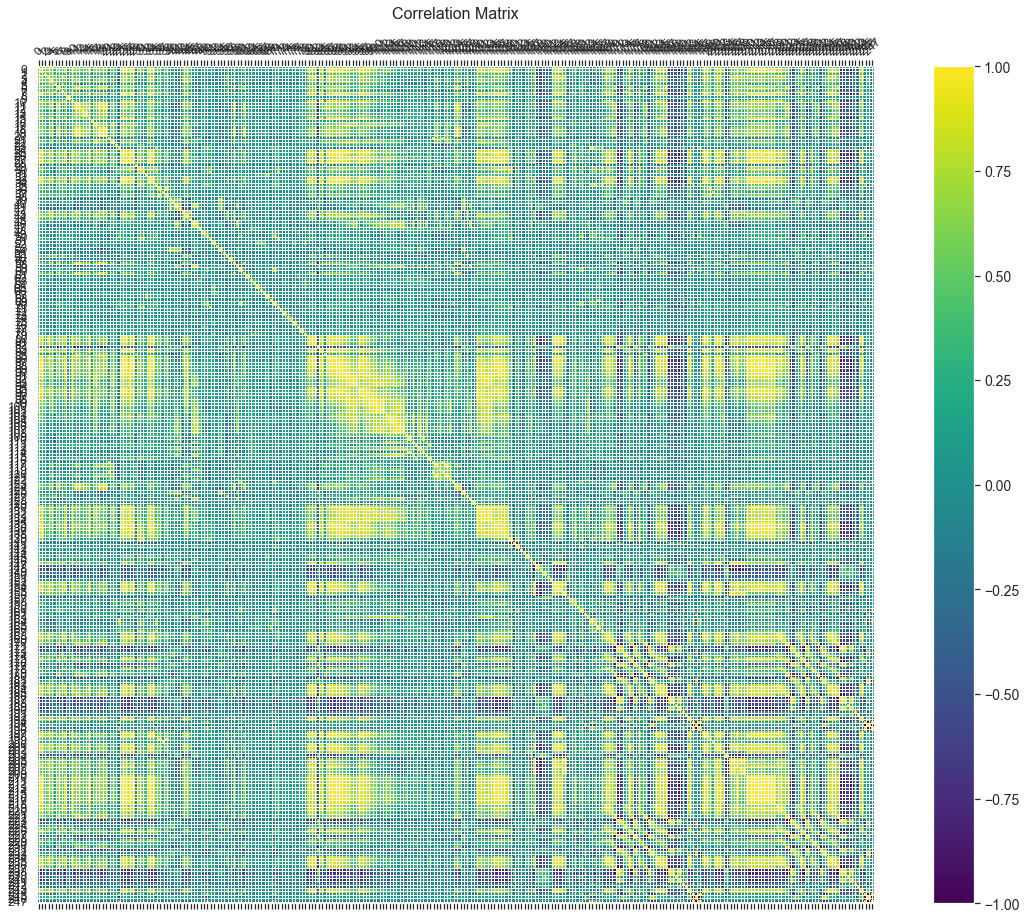

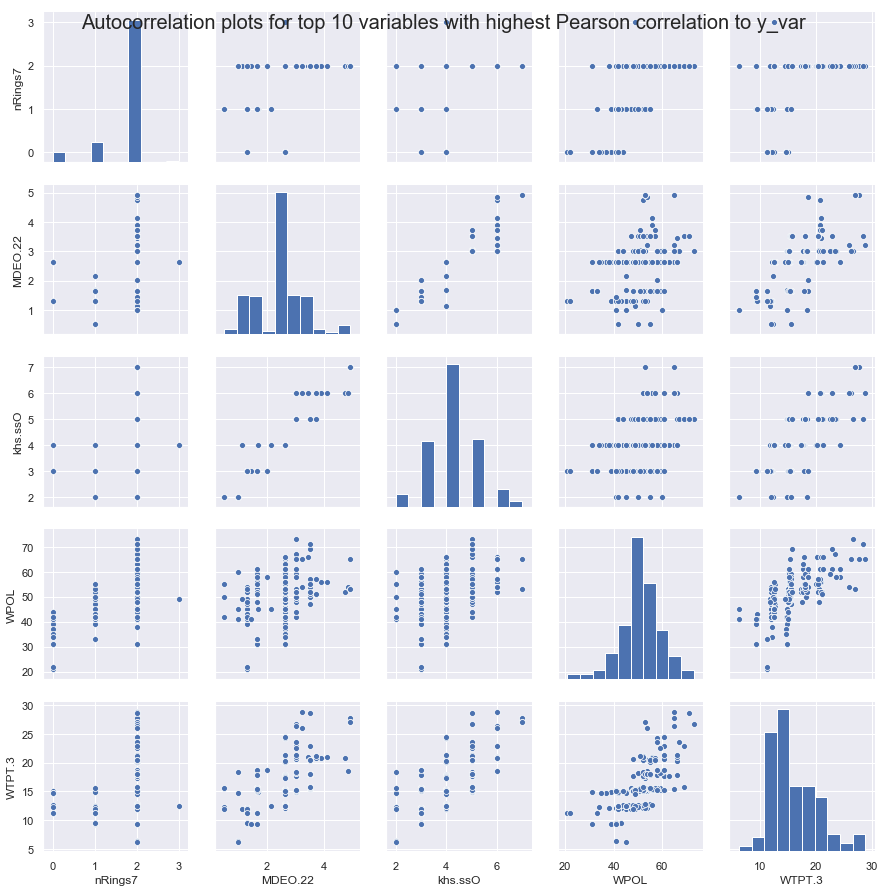

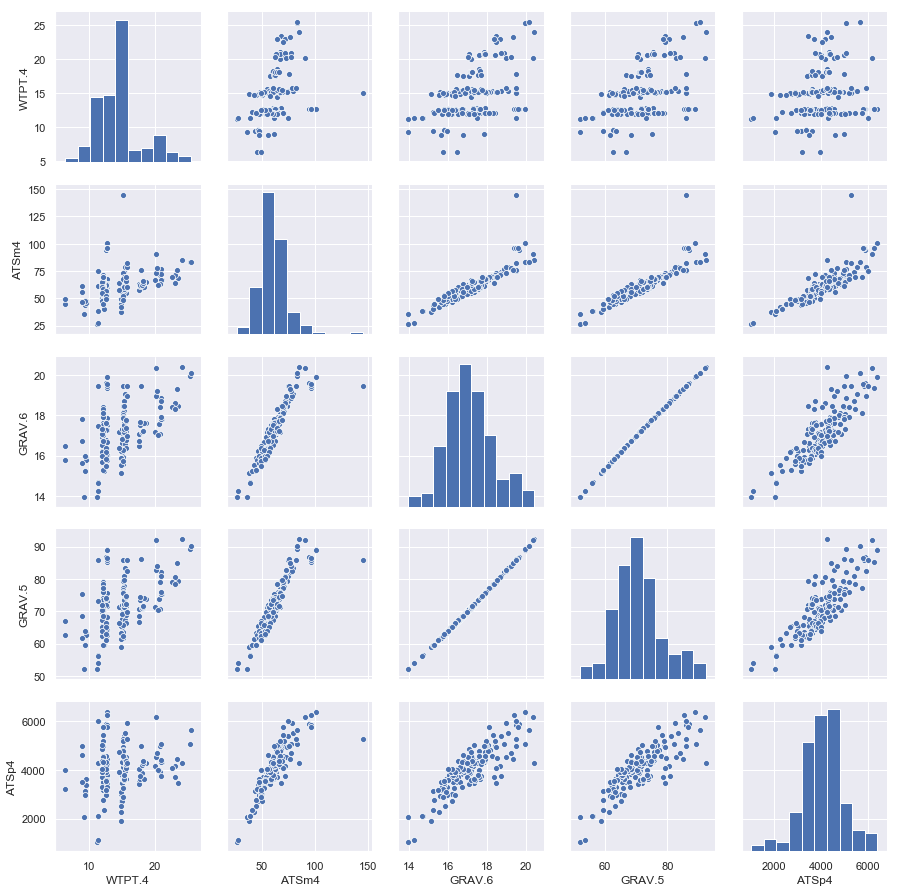

['nRings7', 'MDEO.22', 'khs.ssO', 'WPOL', 'WTPT.3', 'WTPT.4', 'ATSm4', 'GRAV.6', 'GRAV.5', 'ATSp4']


In [8]:
## Feature Analysis

## Correlation - spearmans rank 
corr_matrix = variance_selected.corr(method='spearman')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number,cmap='viridis')
plt.xticks(range(corr_matrix.shape[1]), list(range(corr_matrix.shape[1])), fontsize=12, rotation=45)
plt.yticks(range(corr_matrix.shape[1]), list(range(corr_matrix.shape[1])), fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.axis('image')
plt.title('Correlation Matrix', fontsize=16)

## Correlation with y-variable

corr_yvar = variance_selected.corrwith(y, axis=0, drop=False).sort_values(ascending=False).head(10)
features = corr_yvar.index.values.tolist()

# Feature distributions of top correlated variables
sns.pairplot(variance_selected[features[:5]])
plt.suptitle('Autocorrelation plots for top 10 variables with highest Pearson correlation to y_var',
             size = 20)
sns.pairplot(variance_selected[features[5:]])
plt.show()
print(features)



/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x720 with 0 Axes>

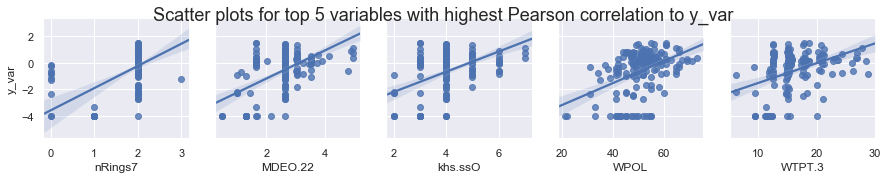

In [9]:
## Highest correlation with y-var

variance_data = variance_selected.copy()
variance_data['y_var'] = y
plt.figure(figsize=(12,10))
sns.pairplot(variance_data, x_vars=features[:5], y_vars=['y_var'], kind='reg')
plt.suptitle('Scatter plots for top 5 variables with highest Pearson correlation to y_var',
             size = 18)
plt.show()

### PCA Analysis

Preliminary PCA analysis indicates that most of the variance within the feature set can be explained by the first 20 components. However, due to the high degree of correlations within the dataset, and the fact that the number of features is higher than the number of data points, the weights estimated for the PC's may be inflated. 

Interestingly, no distinguisable clusters can be identified across the range of y values (Log RA) for the PC plots. 

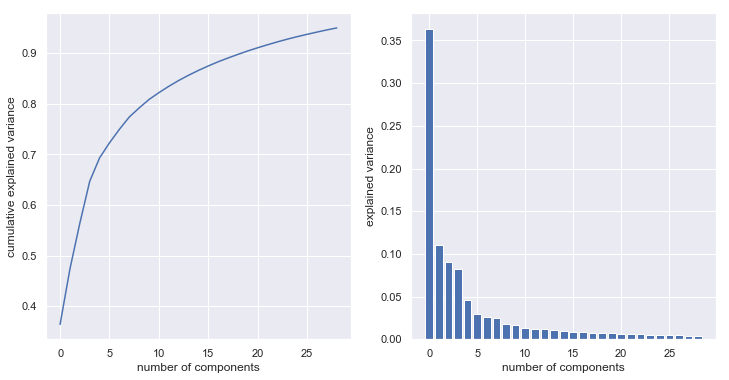

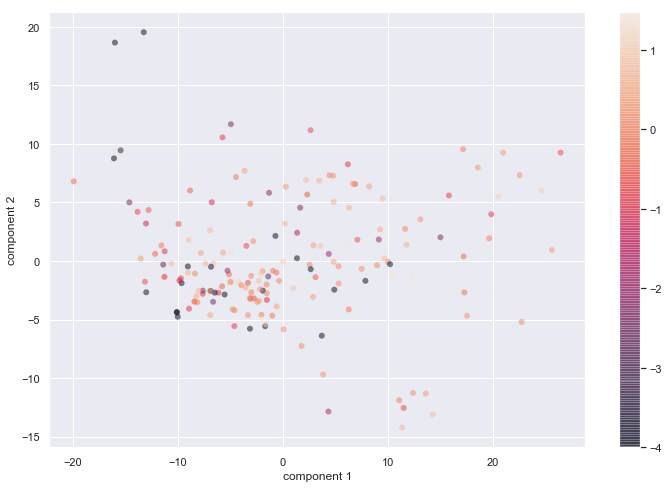

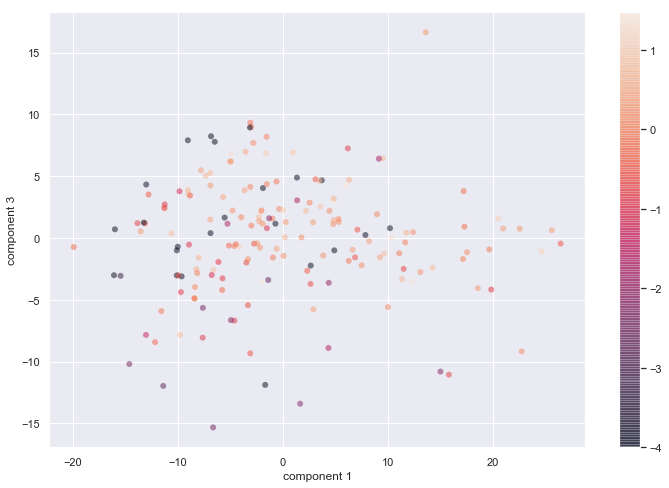

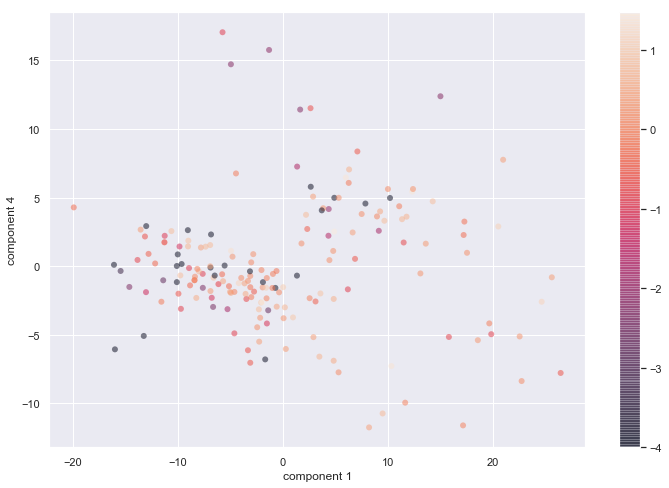

In [10]:
## PCA analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

variance_scaled = StandardScaler().fit_transform(variance_selected.values)

pca_var = PCA(n_components=0.95, svd_solver='full')
projected_var = pca_var.fit_transform(variance_scaled)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(np.cumsum(pca_var.explained_variance_ratio_))
ax[0].set_xlabel('number of components')
ax[0].set_ylabel('cumulative explained variance')
ax[1].bar(range(len(pca_var.explained_variance_ratio_)), height=pca_var.explained_variance_ratio_)
ax[1].set_xlabel('number of components')
ax[1].set_ylabel('explained variance')
#plt.xlim(0,4)
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 1],
            c=y, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 2],
            c=y, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 3")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 3],
            c=y, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 4")
plt.colorbar()
plt.show()



### Correlation-based selection


Spearman correlation coefficients were calculate for the entire dataset. A cut-off of 0.8 was used to drop highly pairwise correlated features. Similar modelling studies focussing on the artemisinin dataset have used the same cut-off (Guha et al (2004) J. Chem. Inf. Comput. Sci., Guha et al (2005) J. Chem. Inf. Model.). 

Future studies might focus on identifying interaction terms, or using the correlation cut-off as a hyperparameter to optimise using preliminary modelling. However, the models would have limited interpretability given that the dataset still has more features than samples. The correlation approach could also preferentially select geometrical or topological molecular descriptors to keep, as they generally provide a global description of the molecular structure vs the local descriptors (e.g number of single/double bonds). 

In [11]:
## Removed highly correlated predictors

print("original shape: ", variance_selected.shape)

corr_matrix = variance_selected.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("number of features with correlations over 0.8: ", len(to_drop))

# Drop columns 
dropped = variance_selected.drop(variance_selected[to_drop], axis=1)

print("updated shape:", dropped.shape)   

dropped.head(4)

original shape:  (179, 248)
number of features with correlations over 0.8:  163
updated shape: (179, 85)


,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nBase,ALogP,nAcid,...,BCUTc.1h,BCUTp.1l,nHBDon,PPSA.3,PNSA.3,DPSA.1,RPCG,RPCS,RNCS,TPSA
0,3.039,282.146724,0,0,2.56,0,3,0,0.8012,0,...,0.267195,4.745096,0,10.042246,-26.548908,216.940423,0.168942,0.185955,2.032461,81.019556
1,5.687,386.209324,1,5,3.44,4,6,0,1.3625,0,...,0.264376,4.471269,0,19.154338,-29.398959,288.071112,0.132376,0.349696,0.963157,82.855988
2,2.746,268.131074,0,0,2.45,0,3,0,0.5412,0,...,0.264340,4.430722,0,11.498865,-30.360719,200.981901,0.172827,0.586998,2.523145,101.389037
3,3.039,282.146724,0,0,2.56,0,3,0,0.8012,0,...,0.267195,4.745096,0,10.040449,-26.576362,217.146933,0.168942,0.185955,2.032461,81.190429


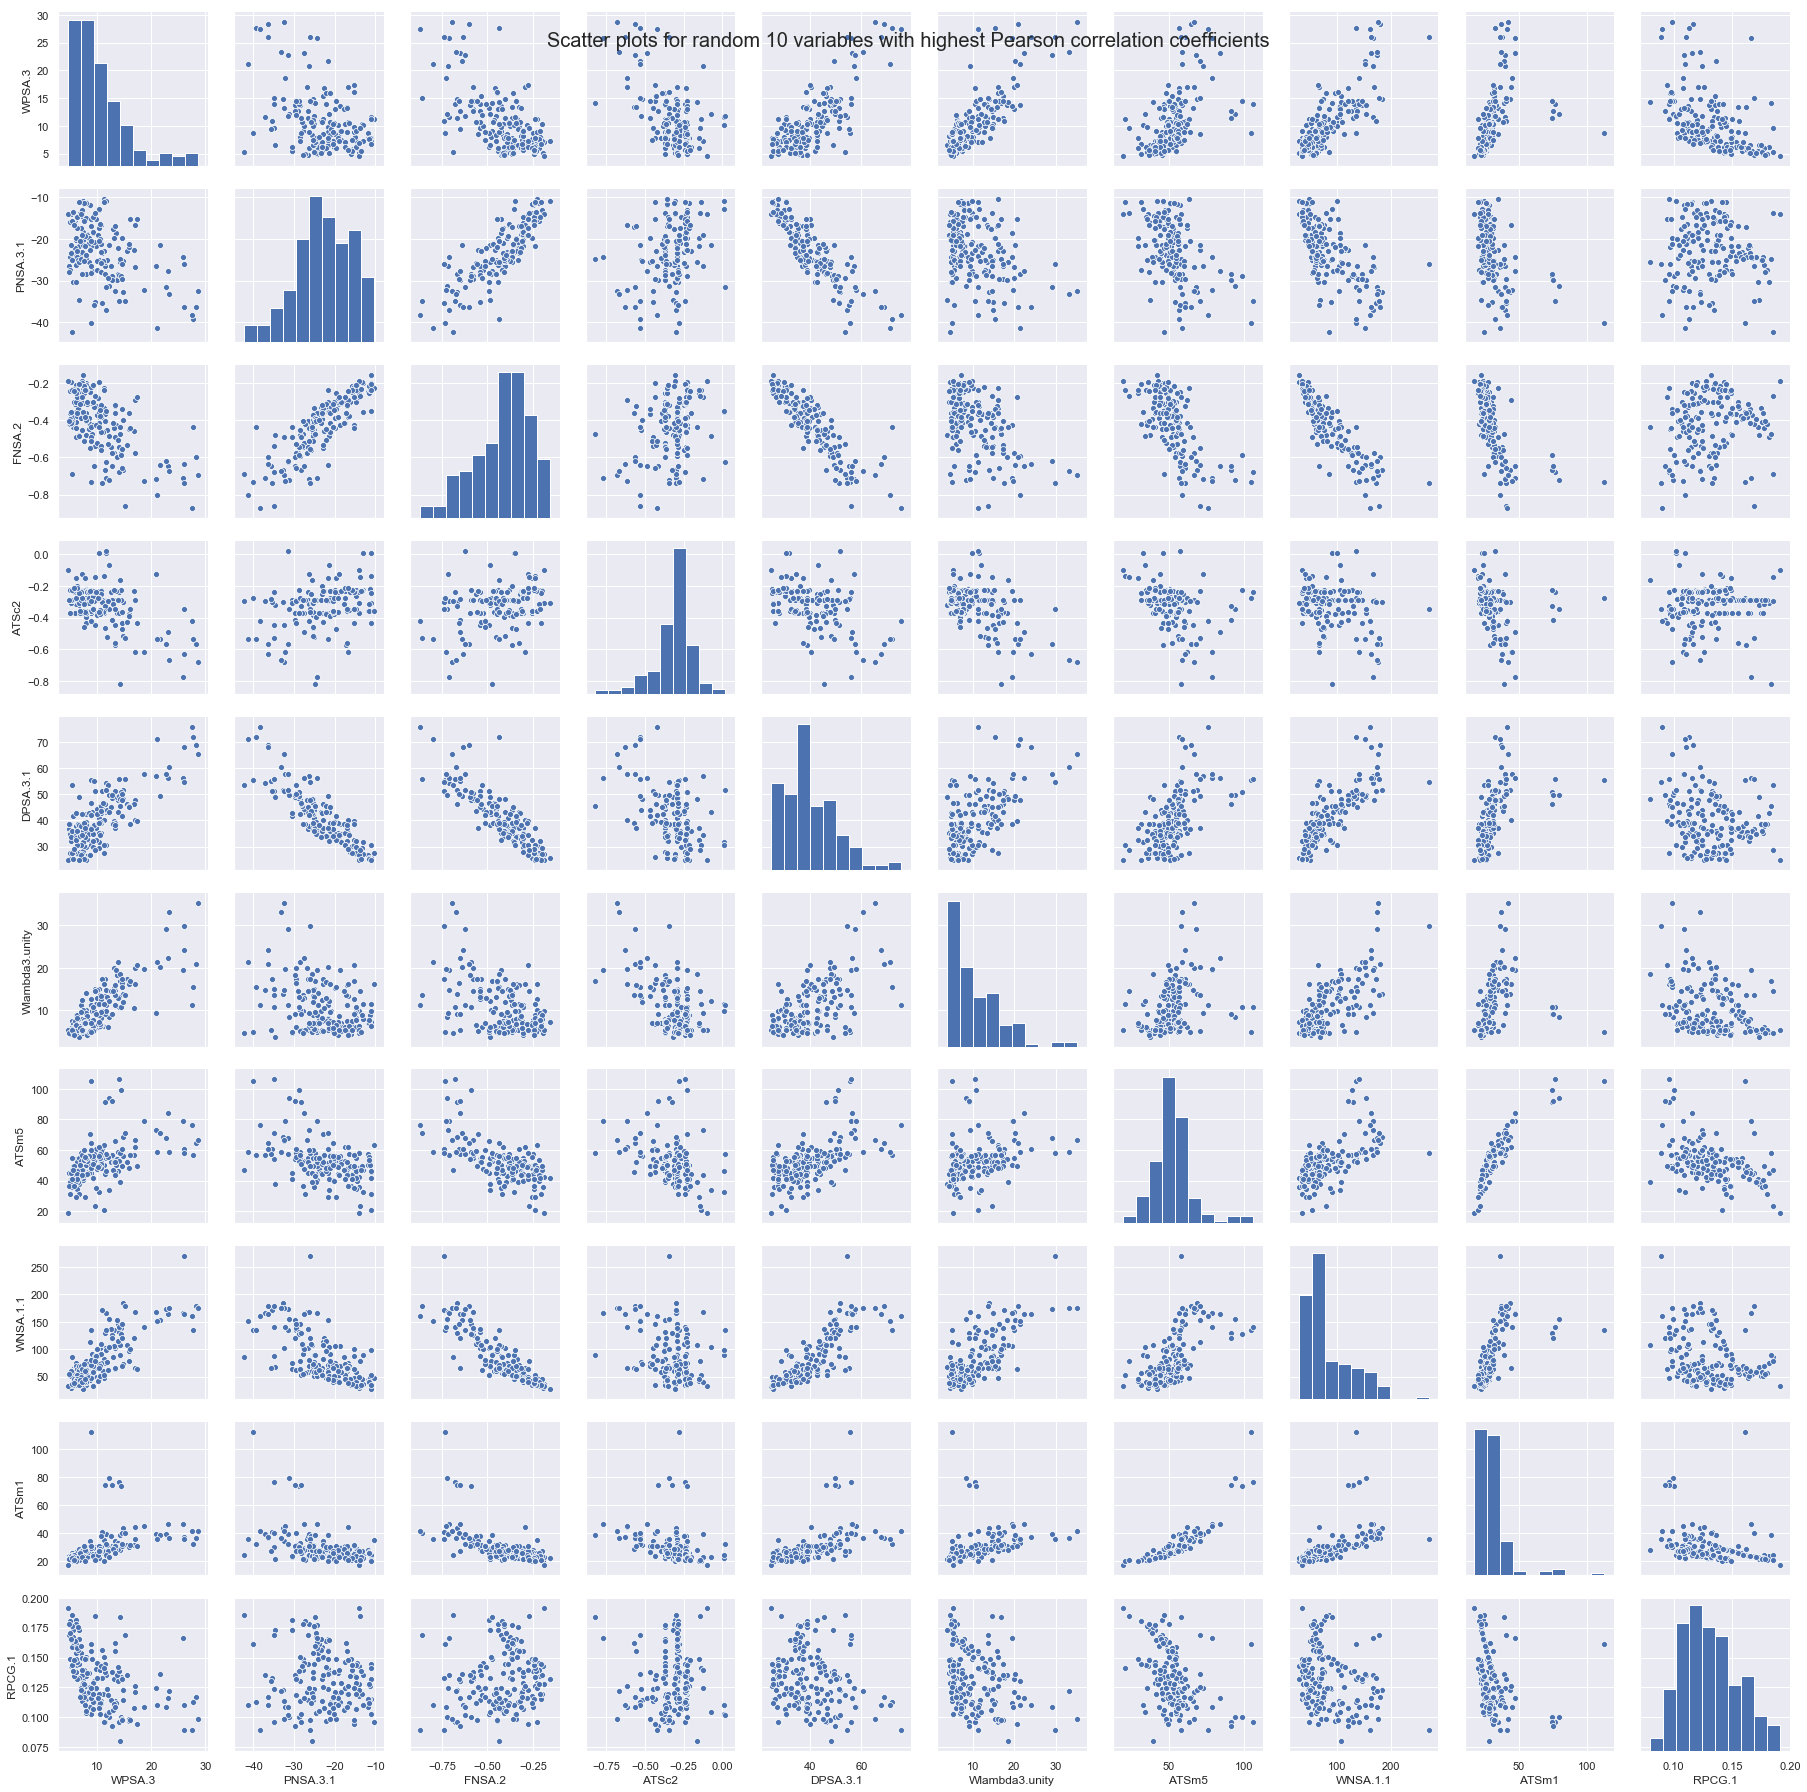

In [12]:
## Sanity check for a random sample of 10 highly correlated variables

highest_corr = variance_selected[to_drop].sample(10, axis=1)

# Feature distributions of top correlated variables
sns.pairplot(highest_corr)
plt.suptitle('Scatter plots for random 10 variables with highest Pearson correlation coefficients',
             size = 20)
plt.show()

dropp corr matrix shape:  (85, 85)


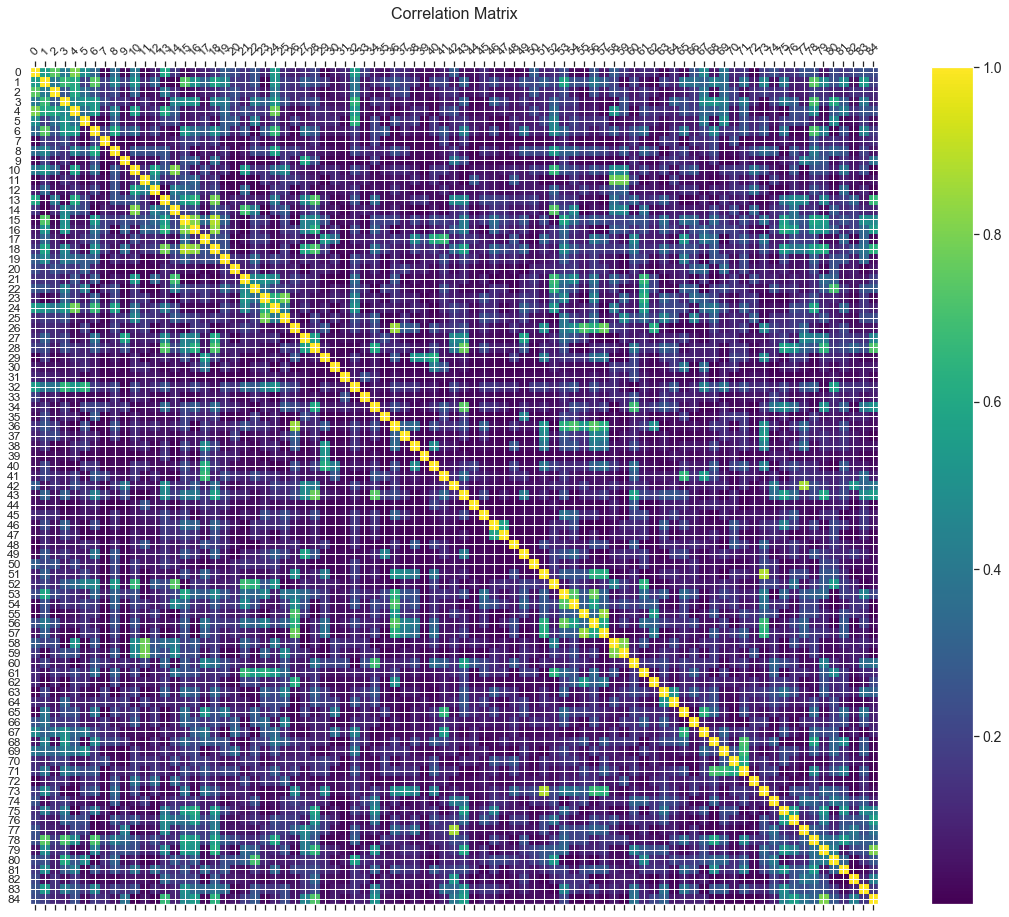

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x720 with 0 Axes>

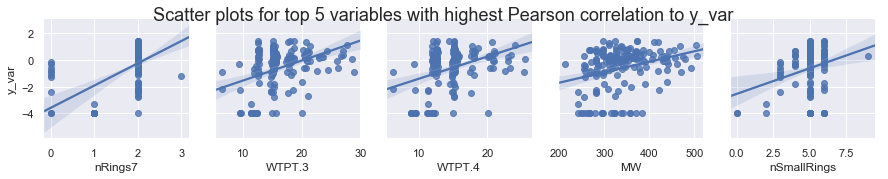

In [13]:
dropped_corr_matrix = dropped.corr().abs()
print("dropp corr matrix shape: ", dropped_corr_matrix.shape)

f = plt.figure(figsize=(19, 15))
plt.matshow(dropped_corr_matrix, fignum=f.number,cmap='viridis')
plt.xticks(range(dropped_corr_matrix.shape[1]), list(range(dropped_corr_matrix.shape[1])), fontsize=12, rotation=45)
plt.yticks(range(dropped_corr_matrix.shape[1]), list(range(dropped_corr_matrix.shape[1])), fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.axis('tight')
plt.title('Correlation Matrix', fontsize=16)
plt.show()


## Correlation with y-variable

corr_yvar = dropped.corrwith(y, axis=0, drop=False).sort_values(ascending=False).head(10)
features_yvar = corr_yvar.index.values.tolist()

## Highest correlation with y-var
dropped_data = dropped.copy()
dropped_data['y_var'] = y
plt.figure(figsize=(12,10))
sns.pairplot(dropped_data, x_vars=features_yvar[:5], y_vars=['y_var'], kind='reg')
plt.suptitle('Scatter plots for top 5 variables with highest Pearson correlation to y_var',
             size = 18)
plt.show()


### PCA with reduced dataset

PCA analysis reveals a reduction in the estimated weights for the first few principal components, most likely due to reduction in the overall correlations present within the dataset. The bar plot shows the overall estimated contribution of the features to the first two principal components. Interestingly, there is significant overlap in the features with larger coefficient estimates from the below Lasso regression, and the estimated weights of the features in contribution of the first principal component (e.g TopoPSA, WIPT.3, Lipinski Failures). 

(136, 85) (136,)
(17, 85) (17,)
(17, 85) (17,)
(136, 85)


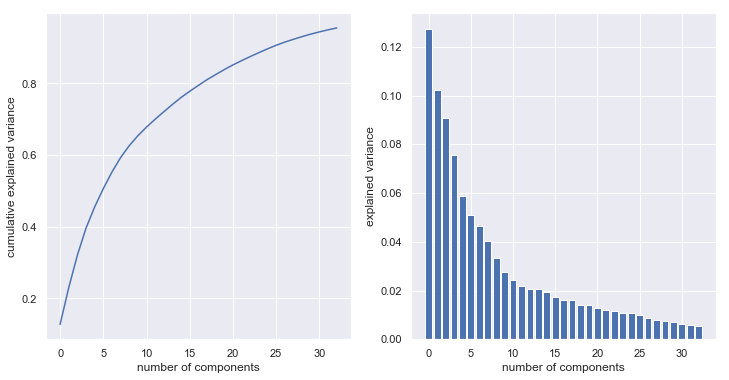

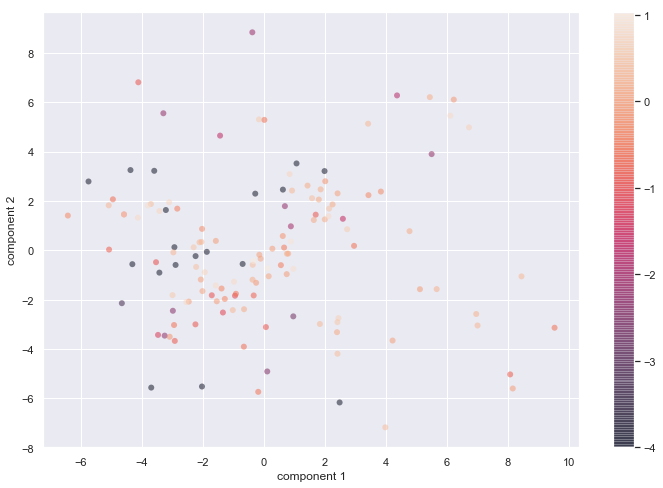

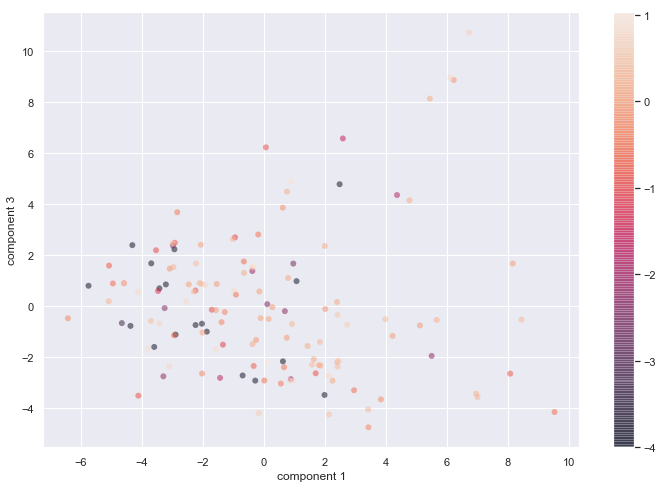

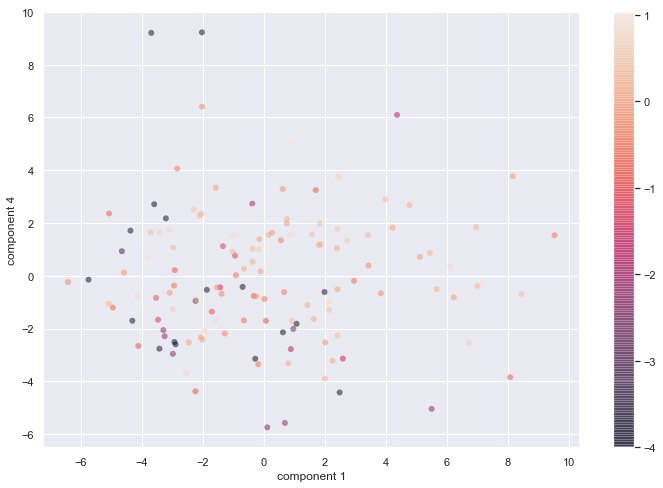

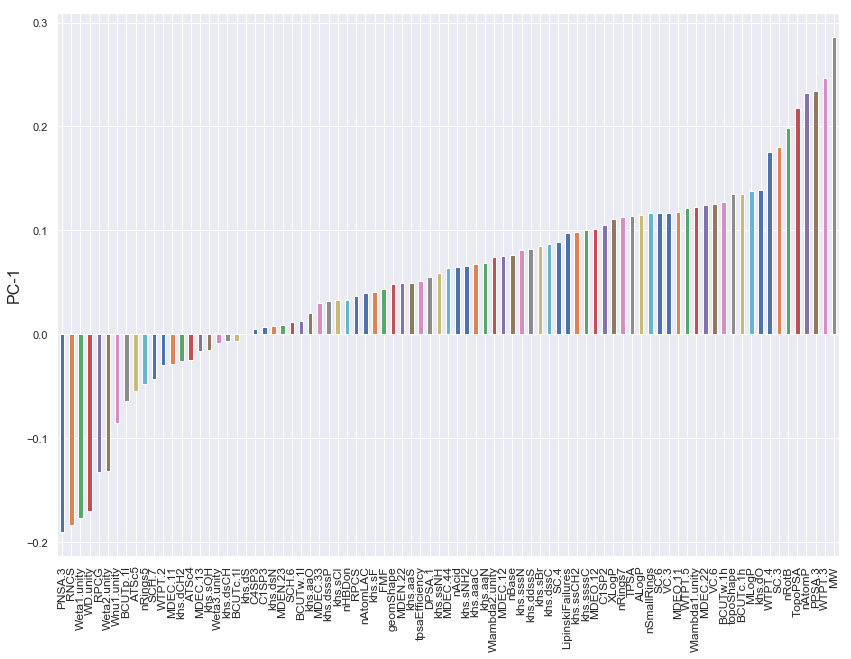

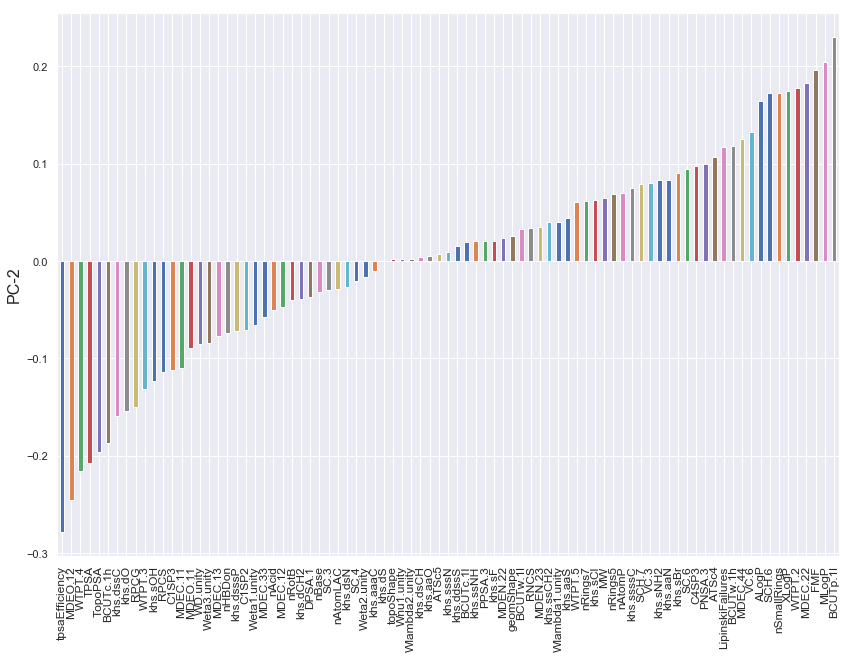

In [14]:
## PCA analysis

from sklearn.decomposition import PCA

y = data['depVar']
## Generate stratified split for there are equal distributions of y-var across the splits
train_idx, valid_idx, test_idx = strat_train_valid_test_split(y, frac_valid=0.1, seed=42)

#Apply split
X = np.array(dropped)

X_train, y_train = (X[train_idx], y[train_idx])
X_valid, y_valid = (X[valid_idx], y[valid_idx])
X_test, y_test = (X[test_idx], y[test_idx])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

pca_var = PCA(n_components=0.95, svd_solver='full')
pca_2 = PCA(n_components=2)
projected_2 = pca_2.fit_transform(X_train_scaled)
projected_var = pca_var.fit_transform(X_train_scaled)

feature_weights = pd.DataFrame(pca_var.components_[0:2],columns=dropped.columns,index = ['PC-1','PC-2'])
recover = pca_var.inverse_transform(projected_var)
print(recover.shape)

def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #print(n)
    plt.figure(figsize=(12,10))
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c = y_train)
   # plt.scatter(xs, ys, c=y[:10])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*4, coeff[i,1]*4, color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 4.15, coeff[i,1] * 4.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 4.15, coeff[i,1] * 4.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.colorbar()
    plt.grid()

# Use only the 2 PCs.
# labels = dropped.columns.tolist()
# biplot(projected_var[:,0:2],np.transpose(pca_var.components_[0:2]), labels=labels)
# plt.show()


fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(np.cumsum(pca_var.explained_variance_ratio_))
ax[0].set_xlabel('number of components')
ax[0].set_ylabel('cumulative explained variance')
ax[1].bar(range(len(pca_var.explained_variance_ratio_)), height=pca_var.explained_variance_ratio_)
ax[1].set_xlabel('number of components')
ax[1].set_ylabel('explained variance')
#plt.xlim(0,4)
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 1],
            c=y_train, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 2],
            c=y_train, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 3")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(projected_var[:, 0], projected_var[:, 3],
            c=y_train, edgecolor='none', alpha=0.5)
            #cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel("component 1")
plt.ylabel("component 4")
plt.colorbar()
plt.show()

# Bar chart of PCA feature weights
#plt.figure()
sorted_weights_pc1 = feature_weights.iloc[0].sort_values()
sorted_weights_pc1.plot(kind='bar', figsize=(14,10))
plt.ylabel("PC-1", fontsize=16)
plt.xticks(fontsize=12)
plt.show()

sorted_weights_pc2 = feature_weights.iloc[1].sort_values()
sorted_weights_pc2.plot(kind='bar', figsize=(14,10))
plt.ylabel("PC-2", fontsize=16)
plt.xticks(fontsize=12)
plt.show()

### Lasso feature selection

Whilst the correlation-based feature selection significantly reduced the number of features, the matrix plot shows that there could still be significantly correlated features (up to 0.8). Lasso regression can be used for further feature selection as the estimated coefficients can be set to zero. LassoCV can be used to select the optimal alpha (the amount of penalisation). 

Lasso picked 61 variables and eliminated the other 24 variables
R2 Score : 0.8733134739345594
optimal alpha chosen by CV on 5 folds:  2.2746818089315517


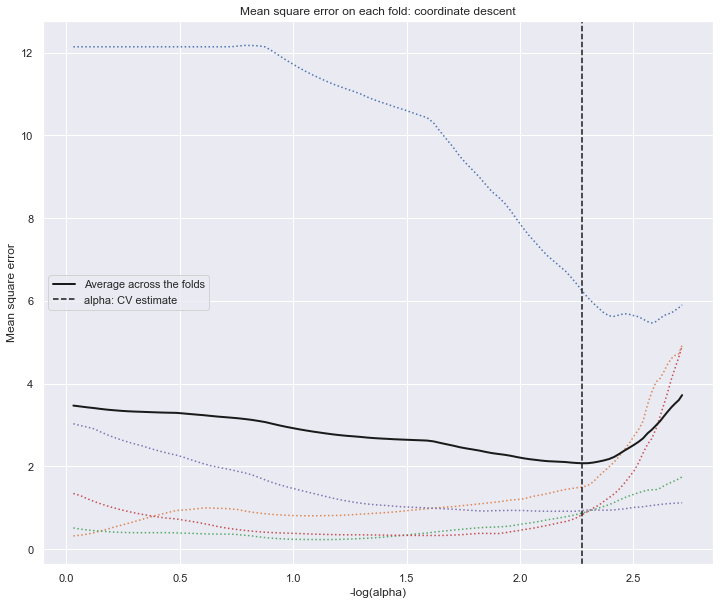

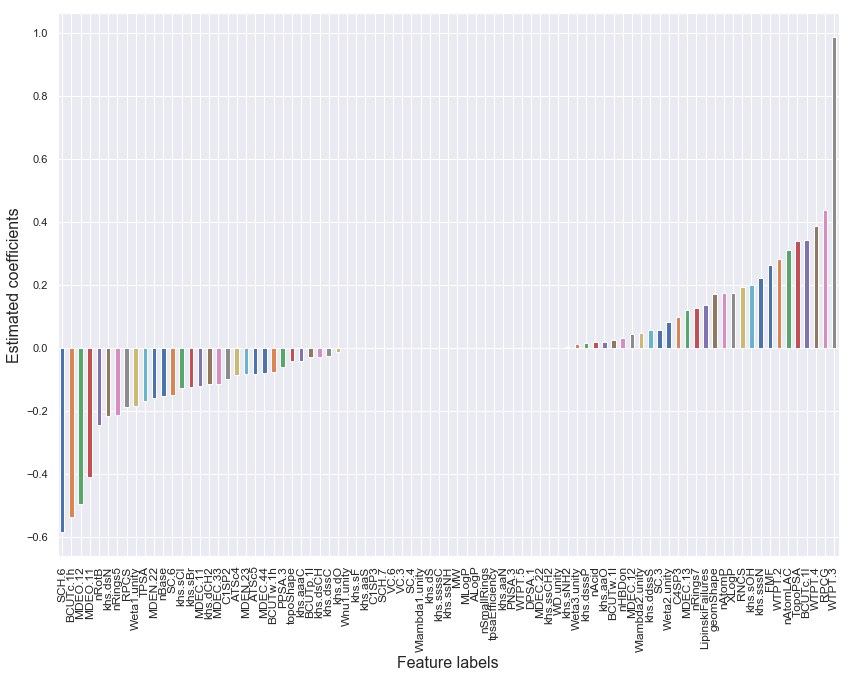

lasso selected shape:  (179, 61)
khs.sOH     0.198103
khs.sssN    0.220803
FMF         0.263295
WTPT.2      0.280261
nAtomLAC    0.309362
TopoPSA     0.340301
BCUTc.1l    0.342149
WTPT.4      0.385110
RPCG        0.438264
WTPT.3      0.985112
dtype: float64


In [15]:
## Feature selection with Lasso

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

eps=1e-3
lasso = LassoCV(cv=5, eps=eps, random_state=42,  max_iter=100000).fit(X_train_scaled, y_train)

coefficients = pd.Series(lasso.coef_, index = dropped.columns)

print("Lasso picked " + str(sum(coefficients != 0)) + " variables and eliminated " +  str(sum(coefficients == 0)) + " variables")
print("R2 Score :", lasso.score(X_valid_scaled, y_valid))

# Display results
m_log_alpha = -np.log10(lasso.alpha_ + eps)
m_log_alphas = -np.log10(lasso.alphas_ + eps)

print("optimal alpha chosen by CV on 5 folds: ", m_log_alpha)
plt.figure(figsize=(12,10))
plt.plot(m_log_alphas, lasso.mse_path_, ':')
plt.plot(m_log_alphas, lasso.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso.alpha_ + eps), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent')
plt.axis('tight')
#plt.ylim(ymin, ymax)
plt.show()


# Bar chart of estimated coefficients 
#plt.figure()
sorted_coeff = coefficients.sort_values()
sorted_coeff.plot(kind='bar', figsize=(14,10))
plt.ylabel("Estimated coefficients", fontsize=16)
plt.xlabel("Feature labels", fontsize=16)
plt.xticks(fontsize=12)
plt.show()

# Keep selected coefficients

selected_coeff = coefficients.loc[coefficients!=0].index.tolist()
lasso_selected = dropped[selected_coeff]
print("lasso selected shape: ", lasso_selected.shape)
print(sorted_coeff.tail(10))


In [207]:
## Test lasso alpha selection with cross-validation
from sklearn.model_selection import KFold

lasso_cv = LassoCV(eps=eps, cv=5, random_state=42, max_iter=100000)
k_fold = KFold(2)

y_train = np.array(y_train)

for k, (train, valid) in enumerate(k_fold.split(X_train_scaled, y_train)):
    print("k fold: %s, train indx: %s, valid indx: %s " % (k, train.shape, valid.shape))
    lasso_cv.fit(X_train_scaled[train], y_train[train])
    print("fold {0} alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X_train_scaled[valid], y_train[valid])))

plt.show()

k fold: 0, train indx: (68,), valid indx: (68,) 
fold 0 alpha: 0.06208, score: -2.19906
k fold: 1, train indx: (68,), valid indx: (68,) 
fold 1 alpha: 0.01999, score: -17.41942


### Variance inflation factors

The Lasso regression resulted in a reduction of features available, but there is still a large degree of variance in calculation of the optimal alpha for different fold of the training data set. Variance inflation factors show which features are most associated with multicollinearity within the dataset. 

Index(['XLogP', 'LipinskiFailures'], dtype='object')
high vifs shape:  (30, 2)
low vifs shape:  (31, 2)
         VIF              cols
26  9.580836          khs.dssC
40  8.422531              SC.6
3   8.396810          nAtomLAC
36  8.200689           khs.sCl
34  7.938041         khs.dsssP
8   7.932089           nRings7
22  7.331880           MDEN.22
28  7.244102          khs.sNH2
58  7.206454              RPCS
44  6.770117             ATSc4
52  6.415511          BCUTc.1l
45  6.135919             ATSc5
6   6.003450             nAcid
54  5.851739          BCUTp.1l
43  5.354759             C4SP3
59  5.059619              RNCS
47  4.606626       Weta1.unity
1   4.028411  LipinskiFailures
29  3.869985           khs.dsN
48  3.846585       Weta2.unity
33  3.623753           khs.aaO
49  3.370940       Weta3.unity
46  3.156830    Wlambda2.unity
50  3.092789          BCUTw.1l
25  2.836116          khs.dsCH
27  2.291170          khs.aaaC
14  2.159376         geomShape
23  2.157629           MDEN.

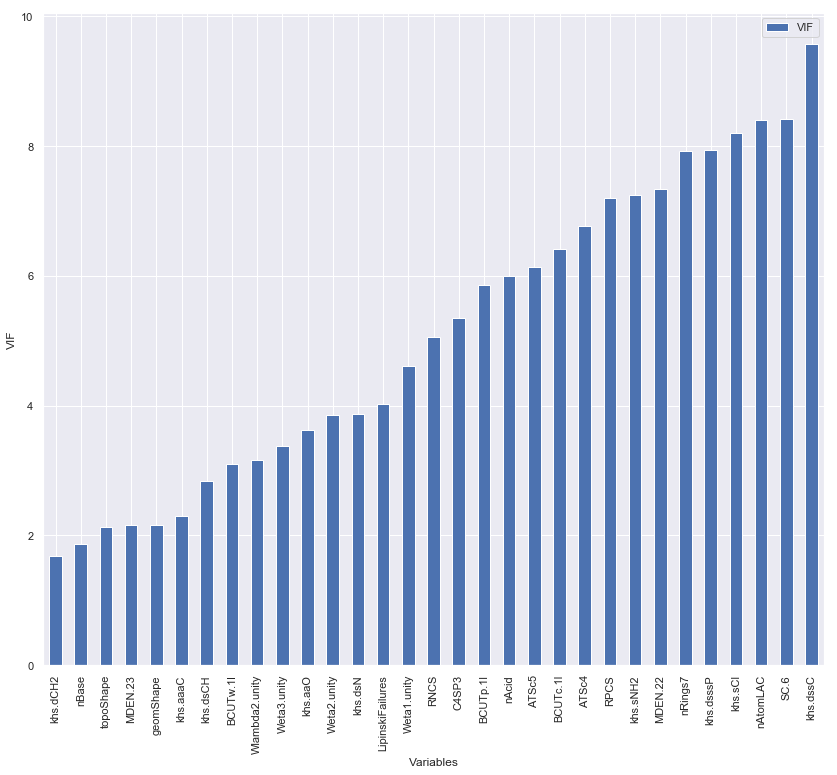

['khs.dssC', 'SC.6', 'nAtomLAC', 'khs.sCl', 'khs.dsssP', 'nRings7', 'MDEN.22', 'khs.sNH2', 'RPCS', 'ATSc4', 'BCUTc.1l', 'ATSc5', 'nAcid', 'BCUTp.1l', 'C4SP3', 'RNCS', 'Weta1.unity', 'LipinskiFailures', 'khs.dsN', 'Weta2.unity', 'khs.aaO', 'Weta3.unity', 'Wlambda2.unity', 'BCUTw.1l', 'khs.dsCH', 'khs.aaaC', 'geomShape', 'MDEN.23', 'topoShape', 'nBase', 'khs.dCH2']


In [220]:
## VIFS

vifs = variance_inflation(lasso_selected)

high_vifs = vifs.loc[vifs['VIF'] > 10]
low_vifs = vifs.loc[vifs['VIF'] < 10]

print("high vifs shape: ", high_vifs.shape)
print("low vifs shape: " , low_vifs.shape)
print(low_vifs)

sorted_low_vifs = low_vifs.sort_values(by='VIF', ascending=True)
sorted_low_vifs.plot(x='cols', kind='bar', figsize=(14,12))
plt.ylabel("VIF")
plt.xlabel("Variables")
plt.show()

low_vifs_columns = low_vifs['cols'].tolist()
print(low_vifs_columns)

In [221]:
selected_vifs = dropped[low_vifs_columns]
print("shape: ", selected_vifs.shape)
selected_vifs.head(4)

shape:  (179, 31)


,khs.dssC,SC.6,nAtomLAC,khs.sCl,khs.dsssP,nRings7,MDEN.22,khs.sNH2,RPCS,ATSc4,...,Weta3.unity,Wlambda2.unity,BCUTw.1l,khs.dsCH,khs.aaaC,geomShape,MDEN.23,topoShape,nBase,khs.dCH2
0,1,0.089576,0,0,0,2,0.0,0,0.185955,-0.097733,...,0.480258,3.325486,11.999,0,0,0.842030,0.0,0.750000,0,0
1,1,0.095819,4,0,0,2,0.0,0,0.349696,-0.094000,...,0.483547,2.583993,11.999,0,0,0.955475,0.0,0.857143,0,0
2,1,0.095819,0,0,0,2,0.0,0,0.586998,-0.093663,...,0.464861,3.091289,11.999,0,0,0.780229,0.0,0.750000,0,0
3,1,0.089576,0,0,0,2,0.0,0,0.185955,-0.097733,...,0.480259,3.321834,11.999,0,0,0.842642,0.0,0.750000,0,0


In [222]:
dropped['y_var'] = y 
lasso_selected['y_var'] = y

print("shape correlation selected dataset: ", dropped.shape)
print("shape lasso seleted dataset: ", lasso_selected.shape)

dropped.to_csv("qsar_correlation_processed.csv", index=False)
lasso_selected.to_csv("qsar_lasso_processed.csv", index=False)
selected_vifs.to_csv("qsar_vifs_processed.csv", index=False)

shape correlation selected dataset:  (179, 86)
shape lasso seleted dataset:  (179, 62)


/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
